# Intrinsic tail of Gaussian Mixture
The following code samples trajectories for the RWM algorithm and for the Skipping Sampler when the target distribution is the intrinsic tail of a Gaussian mixture. The problem is considered in dimension $2$ and in dimension $50$ and the mixtures have random weights and consist of $20$ Gaussian distributions with random centers and random covariance matrices. The following code has been used to generate Figures 3 and 4.

In [37]:
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import special_ortho_group #needed for random rotations

def GaussianPDF(x, mu, detSigma, invSigma):
    """
    GaussianPDF returns, up to a constant factor, the value of the multivariate d-dimensional 
    Gaussian probability density with mean mu and covariance matrix Sigma evaluated at the point x.
    
    Parameters
    ----------
    :x: is the d-dimensional vector describing the point at which the density is evaluated
    :mu: is the d-dimensional vector describing the mean of the Gaussian distribution
    :detSigma: is the determinant of the covariance matrix Sigma
    :invSigma: is the inverse of the covariance matrix Sigma
    
    Note that the density does not account for the normalization constant (2 * np.pi) ** (-d/2)
    
    Returns
    ----------
    The Gaussian density evaluated at the point x
    """ 
    
    return (detSigma ** (-1/2)) * np.exp(-.5 * (x - mu).T @ invSigma @ (x - mu))

def LogTarget(x, d, NumberOfModes, ModeLocations, invSigmas, detSigmas, Weights):
    """
    LogTarget returns the density of the mixture of several multivariate d-dimensional Gaussian 
    distributions evaluated at the point x.
    
    Parameters
    ----------
    :x: is the d-dimensional vector describing the point at which the density is evaluated
    :d: is the dimension of the probability space
    :NumberOfModes: is the number of Gaussian distribution in the mixture
    :ModeLocations: is the NumberOfModes x d array containing the mean of each of the NumberOfModes 
                    Gaussian distributions
    :detSigmas: is a NumberOfModes array containing the value of the determinants of the covariance 
                matrices of the various Gaussian distributions
    :invSigmas: is a (NumberOfModes * d) x (NumberOfModes * d) matrix whose d x d diagonal blocks 
                are the inverse of the covariance matrices of the various Gaussian distributions 
    :Weights: is the NumberOfModes array containing the weights given in the mixture to the various 
              Gaussian distributions
    
    Note that the density does not account for the normalization constant (2 * np.pi) ** (-d/2)
    
    Returns
    ----------
    The logarithm of the the mixture Gaussian density evaluated at the point x
    """ 
        
    return np.log(np.average([GaussianPDF(x, ModeLocations[i], detSigmas[i], invSigmas[(i*d):((i+1)*d),(i*d):((i+1)*d)] ) for i in range(NumberOfModes)], weights=Weights))

def GenerateTarget(d, NumberOfModes, span):
    """
    GenerateTarget returns a random set of parameters for creating a mixture of several multivariate Gaussian 
    distributions.
    
    Parameters
    ----------
    :d: is the dimension of the probability space
    :NumberOfModes: is the number of Gaussian distribution in the mixture
    :span: variance of the distribution sampling the centers of the modes
    
    The ModeLocations are sampled using a multivariate Gaussian distribution centered at the origin 
    with covariance matrix which is scaled using the scalar span
    
    Returns
    ----------
    ModeLocations, invSigmas, detSigmas, Weights
    """ 
    
    # Random weights are drawn for the NumberOfModes distributions in the Gaussian mixture and are rescaled 
    # to sum up to one.
    Weights = np.random.rand(NumberOfModes)
    Weights = Weights / np.sum(Weights)
    
    # Generate the centers of the NumberOfModes Gaussian distribution at random
    # span is variance of the distribution sampling the centers of the modes and 
    # determines how spread out they are
    ModeLocations = np.random.multivariate_normal(np.zeros(d), span*np.identity(d), size=NumberOfModes)  

    # Generate random covariance matrices for the Gaussian mixture and store them as diagonal blocks
    # into a single giant block-diagonal matrix
    invSigmas = np.zeros((NumberOfModes*d,NumberOfModes*d))
    detSigmas = np.zeros(NumberOfModes)
    for i in range(NumberOfModes):
        # Random rotation matrix is sampled
        R = special_ortho_group.rvs(d)
        # Random diagonal terms are sampled in an i.i.d. fashion for the i-th covariance matrix
        variances = np.random.exponential(4, d) 
        # The determinant of the i-th covariance matrix is calculated
        detSigmas[i] = np.prod(variances)
        # The inverse of each covariance matrix is obtained directly by taking the diagonal matrix with
        # the reciprocals and then applying a random rotation 
        invSigmas[(i*d):((i+1)*d),(i*d):((i+1)*d)] = R @ np.diag(np.reciprocal(variances)) @ R.T
        
    return ModeLocations, invSigmas, detSigmas, Weights
        
def GenerateDirection(d, PropCovariance):
    """
    GenerateDirection returns a random direction in R^d sampled according to a multivariate zero-mean 
    Gaussian distribution and given covariance matrix.
    
    Parameters
    ----------
    :d: is the dimension of the probability space
    :PropCovariance: is the covariance matrix of the proposal distribution
        
    Returns
    ----------
    A d-dimensional vector of unit norm sampled
    """
    
    v = np.random.multivariate_normal(np.zeros(d), PropCovariance)
    return v / np.linalg.norm(v)

def GenerateDistance(d, Direction, InvCov):
    """
    GenerateDistance returns a random distance sampled from the proposal density conditionally on a given direction
    
    Parameters
    ----------
    :d: is the dimension of the probability space
    :Direction: is the d-dimensional array describing the direction
    :invCov: is the inverse of the covariance matrix of the Gaussian proposal deensity
    
    GenerateDistance assumes that the proposal density is Gaussian. 
    
    Returns
    ----------
    A positive scalar descriibing the random distance
    """
    
    return (Direction.T @ InvCov @ Direction)**(-1/2) * np.sqrt(np.random.chisquare(d))
    
def PlotIntrinsicTail(NumberOfModes, ModeLocations, invSigma, detSigmas, Weights, Threshold, xmin, xmax, ymin, ymax, res=0.2):
    """
    PlotIntrinsicTail plots the intrinsic tail of the given Gaussian mixture corresponding to the points with
    a probability lower than exp(-Threshold)
        
    Parameters
    ----------
    :NumberOfModes: is the number of Gaussian distribution in the mixture
    :ModeLocations: is the NumberOfModes x d array containing the mean of each of the NumberOfModes Gaussian 
                    distributions
    :detSigmas: is a NumberOfModes array containing the value of the determinants of the covariance matrices 
                of the various Gaussian distributions
    :invSigmas: is a (NumberOfModes * d) x (NumberOfModes * d) matrix whose d x d diagonal blocks are the 
                inverse of the covariance matrices of the various Gaussian distributions 
    :Weights: is the NumberOfModes array containing the weights given in the mixture to the various Gaussian 
              distributions
    :Threshold: is the threshold that defines the intrinsic tail
    :x(y)min(max): axes limits for the plot
    :res: is the resolution of the contour plot
    
    Returns
    ----------
    The countour plot of the intrinsic tail
    """
    fontsize = 24
    xx = np.arange(xmin, xmax, res)
    yy = np.arange(ymin, ymax, res)
    zz = np.array([[LogTarget(np.array([x,y]), d, NumberOfModes, ModeLocations, invSigmas, detSigmas, Weights) for x in xx] for y in yy])
    fig, ax = plt.subplots()
    plt.contourf(xx, yy, zz, levels = Threshold)
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([ymin,ymax])
    ax.set_aspect("equal")
    fig = plt.gcf()
    fig.set_size_inches(10,10)
    plt.xticks(fontsize=0.7*fontsize)
    plt.yticks(fontsize=0.7*fontsize)
    plt.show()

# Intrinsic tail of Gaussian mixture in dimension $d=2$

We consider a mixture of $20$ Gaussian distributions in dimension $2$ and consider its intrinsic tail, defined as the region where the logarithm of its density is smaller than ```-Threshold```. We first generate at random the centers and the covariance matrices of the distribution in the mixture and then plot the corresponding intrinsic tail. We also define the parameters of the Gaussian proposal density, which is the same for both algorithms and has been tuned so that the RWM algorithm has an average acceptance rate of 0.2336 (see Appendix below).

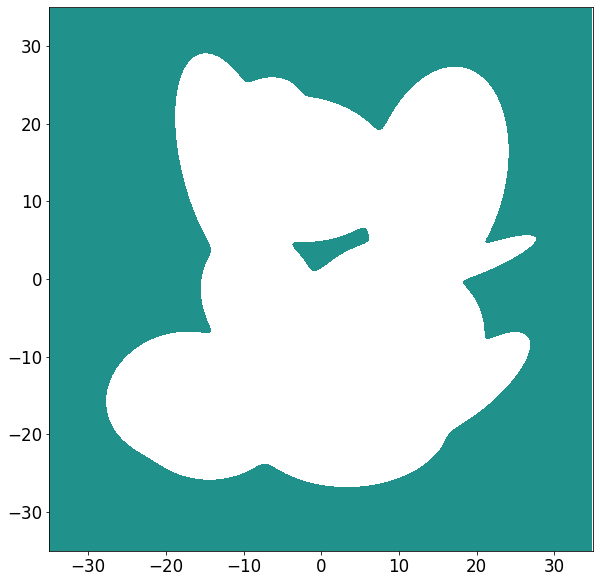

In [89]:
d = 2
NumberOfModes = 20
Threshold = 15 # Threshold that indirectly defines the intrinsic tail

np.random.seed(15)
ModeLocations, invSigmas, detSigmas, Weights = GenerateTarget(d, NumberOfModes, span=100)

# axes limits for plotting
[xmin,xmax] = [-35,35]
[ymin,ymax] = [-35,35]

def BelongsToTail(x, Threshold):
    
    return -LogTarget(x, d, NumberOfModes, ModeLocations, invSigmas, detSigmas, Weights) >= Threshold

def NegativeLogTarget(x):
    
    return -LogTarget(x, d, NumberOfModes, ModeLocations, invSigmas, detSigmas, Weights)

PlotIntrinsicTail(NumberOfModes, ModeLocations, invSigmas, detSigmas, Weights, [-200, -15], xmin, xmax, ymin, ymax, 0.2)

# Define proposal density parameters, identical both for the RWM and Skipping Sampler.
# It has been tuned so that the RWM algorithm has an average acceptance rate of 0.2336 (see Appendix below).
PropVar = 1.6
PropCovariance = PropVar*np.identity(d)
InvCov = np.linalg.inv(PropCovariance)

## Skipping Sampler in dimension $d=2$

We sample from the intrinsic tail of the Gaussian mixture generated above using the Skipping Sampler. The algorithm is started at the origin, which does not belong to the intrinsic tail, and hence starts by skipping in a random direction till the tail is reached. Note that, since the complement of the intrinsic tail is a bounded region, we set the halting index $K=+\infty$.

In [90]:
steps = 10000

# Sample the first point starting by skipping from the origin till reaching the intrinsic tail
np.random.seed(1)
IsOutside = True
IntermediateLocation = np.zeros(d)
Direction = GenerateDirection(d, PropCovariance)
while IsOutside:
    IntermediateLocation = IntermediateLocation + GenerateDistance(d, Direction, InvCov,) * Direction;
    if BelongsToTail(IntermediateLocation, Threshold):
        IsOutside = False
Location = IntermediateLocation 

InitialLocation = Location # Save the starting point so that it can be used also for the RWM algorithm

# Variable initialization
Locations = np.zeros((steps, d)) # Allocate array for the whole trajectory
AcceptedSteps = np.zeros(steps, dtype=int) # Keeps track of whether a step was accepted (1) or not (0)
SkipsCounter = np.zeros(steps, dtype=int) # Keeps track of the number of skips in each skipping excursion
SkipFlag = np.zeros(steps, dtype=int) # Keeps track of whether a move was RW (0) or a true skipping move (1)
TargetEvaluations = 0

# Trajectory generation
t = time.time()
np.random.seed(2021) # For reproducibility
LogCoins = np.log(np.random.rand(steps)) # Pre-sample all accept-reject coins ahead of time
for i in range(steps):
    IsOutside = True # Keep tracks if the current point is outside (True) or inside (False) the intrinsic tail
    Locations[i] = Location # Stores previous point in the trajectory
    IntermediateLocation = Location

    Direction = GenerateDirection(d, PropCovariance) # pick a random direction
    
    # Keep extending the proposal by skipping in the same direction until either:
    # - the halting index is reached
    # - the proposed point is inside the intrinsic tail
    # However, the halting index is set to +inf, since the complement of the intrinsic tail is bounded 
    # by construction, therefore the first condition is never met and therefore is omitted.
    while IsOutside:
        IntermediateLocation = IntermediateLocation + GenerateDistance(d, Direction, InvCov) * Direction;
        SkipsCounter[i] += 1 # We keep track of the number of skips in each skipping excursion
        TargetEvaluations +=1
        if BelongsToTail(IntermediateLocation, Threshold):
            IsOutside = False       
    ProposedLocation = IntermediateLocation
    
    # Acceptance/rejection step
    # Proposed points which are outside the intrinsic tail are rejected automatically
    TargetEvaluations +=3
    if NegativeLogTarget(Location) - NegativeLogTarget(ProposedLocation) >= LogCoins[i] and BelongsToTail(ProposedLocation, Threshold):
        Location = ProposedLocation
        AcceptedSteps[i] = 1
        if SkipsCounter[i]>1:
            SkipFlag[i] += 1
elapsed = time.time() - t
print("Time =",np.round(elapsed,3),"sec")

# Trajectory statistics
AcceptanceRate = np.mean(AcceptedSteps)
AvgSkips = np.mean(SkipsCounter)
TotalSkips = np.sum(SkipFlag)
print("Acceptance rate =", AcceptanceRate)
print("Average number of skips =", AvgSkips)
print("Successful skipping moves =", TotalSkips)
print("Target evaluations =", TargetEvaluations)
        

Time = 17.599 sec
Acceptance rate = 0.4327
Average number of skips = 7.3589
Successful skipping moves = 1973
Target evaluations = 103589


We first show the scatter plot of the Skipping Sampler trajectory and then show the trajectory of the first coordinate alone.

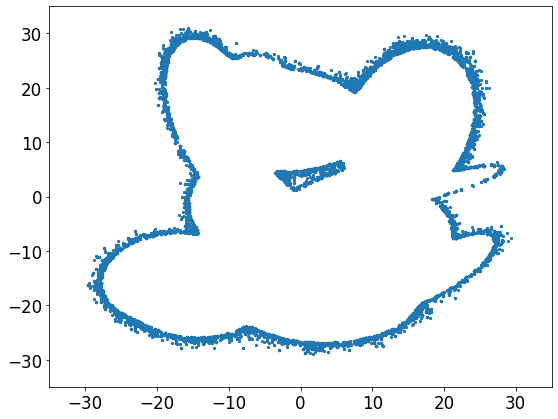

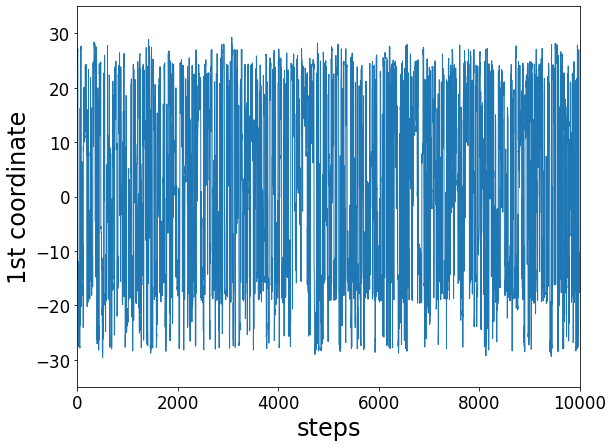

In [91]:
fontsize = 24
markersize = 5
fig, ax = plt.subplots()
plt.scatter(Locations[:,0], Locations[:,1], s=markersize)
fig.set_size_inches(9,7)
plt.xlim(-35, 35)
plt.ylim(-35, 35)
plt.xticks(fontsize=0.7*fontsize)
plt.yticks(fontsize=0.7*fontsize);
plt.savefig('Skipping_2D_10000steps.png', dpi=300, bbox_inches='tight', pad_inches = 0.1)
plt.show()

plt.plot(Locations[:,0], linewidth=1)
fig = plt.gcf()
fig.set_size_inches(9,7)
plt.ylim(-35, 35);
plt.xlim(0, len(Locations[:,0]));
plt.xlabel('steps', fontsize=fontsize)
plt.ylabel('1st coordinate', fontsize=fontsize)
plt.xticks(fontsize=0.7*fontsize)
plt.yticks(fontsize=0.7*fontsize);
plt.savefig('Skipping_2D_10000steps_1stcoordinate.png', dpi=300, bbox_inches='tight', pad_inches = 0.1)
plt.show()

## RWM in dimension $d=2$

In [92]:
steps = 10000

# INITIALIZATION 
Location = InitialLocation # Same initial point as the Skipping Sampler 

# Variable initialization
LocationsRW = np.zeros((steps, d)) # Allocate array for the whole trajectory
AcceptedStepsRW = np.zeros(steps, dtype=int) # Keeps track of whether a step was accepted (1) or not (0)
TargetEvaluationsRW = 0

# TRAJECTORY 
t = time.time()
np.random.seed(2021) # For reproducibility
LogCoins = np.log(np.random.rand(steps)) # Pre-sample all accept-reject coins ahead of time

for i in range(steps):
    LocationsRW[i] = Location
    IntermediateLocation = Location
    
    # Gaussian RW proposal that, to mirror the Skipping Sampler, is performed in two steps:
    # 1) sampling a direction 
    # 2) sampling a distance conditionally on the direction sampled in (1)
    Direction = GenerateDirection(d, PropCovariance) #pick a direction
    ProposedLocation = IntermediateLocation + GenerateDistance(d, Direction, InvCov) * Direction
    
    # Acceptance/rejection step
    # Proposed points which are outside the intrinsic tail are rejected automatically
    TargetEvaluationsRW += 3
    if NegativeLogTarget(Location) - NegativeLogTarget(ProposedLocation) >= LogCoins[i] and BelongsToTail(ProposedLocation, Threshold):
        Location = ProposedLocation
        AcceptedStepsRW[i] = 1
        
elapsed = time.time() - t
print("Time =",np.round(elapsed,3),"sec")

# Trajectory statistics
AcceptanceRateRW = np.mean(AcceptedStepsRW)
print("Average Acceptance Rate RW =", AcceptanceRateRW)
print("Target evaluations =", TargetEvaluationsRW)


Time = 5.887 sec
Average Acceptance Rate RW = 0.2368
Target evaluations = 30000


We first show the scatter plot of the RWM trajectory and then show the trajectory of the first coordinate alone.

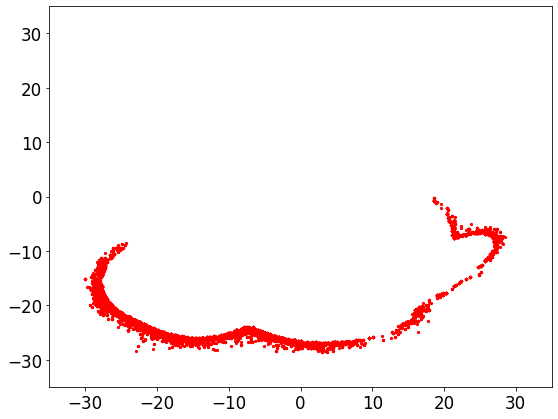

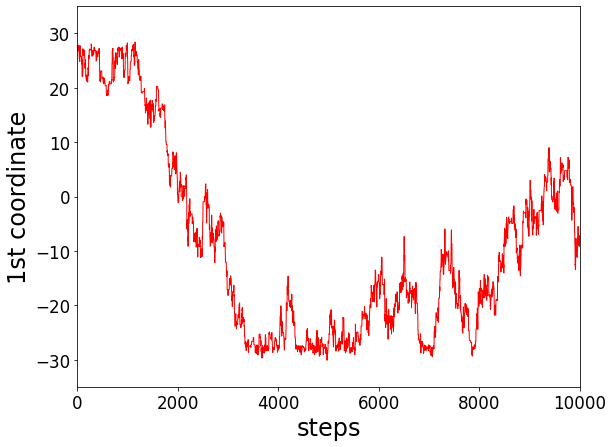

In [93]:
fontsize = 24
markersize = 5
fig, ax = plt.subplots()
plt.scatter(LocationsRW[:,0], LocationsRW[:,1], color='red',s=markersize)
fig.set_size_inches(9,7)
plt.xlim(-35, 35)
plt.ylim(-35, 35)
plt.xticks(fontsize=0.7*fontsize)
plt.yticks(fontsize=0.7*fontsize);
plt.savefig('RW_2D_10000steps.png', dpi=300, bbox_inches='tight', pad_inches = 0.1)
plt.show()

plt.plot(LocationsRW[:,0], color='red', linewidth=1)
fig = plt.gcf()
fig.set_size_inches(9,7)
plt.ylim(-35, 35);
plt.xlim(0, len(LocationsRW[:,0]));
plt.xlabel('steps', fontsize=fontsize)
plt.ylabel('1st coordinate', fontsize=fontsize)
plt.xticks(fontsize=0.7*fontsize)
plt.yticks(fontsize=0.7*fontsize);
plt.savefig('RW_2D_10000steps_1stcoordinate.png', dpi=300, bbox_inches='tight',pad_inches = 0.1)
plt.show()

We compare number of evaluations of the target distribution

In [95]:
np.round(TargetEvaluations/TargetEvaluationsRW,3)

3.453

## Appendix: RWM tuning for dimension $d=2$

We report here the tuning we performed for the proposal density of the RWM algorithm. Note that since we need a starting point in the intrinsic tail for each run, we generate it at random by skipping from the origin.

In [61]:
tuning_runs = 30
steps = 5000

PropVar = 1.6
PropCovariance = PropVar*np.identity(d)
InvCov = np.linalg.inv(PropCovariance)

AverageAcceptanceRate = np.zeros(tuning_runs)

for k in range(tuning_runs):
    
    # Variable initialization
    Location = InitialLocation # Same initial point as the Skipping Sampler 
    LocationsRW = np.zeros((steps, d)) # Allocate array for the whole trajectory
    AcceptedStepsRW = np.zeros(steps, dtype=int) # Keeps track of whether a step was accepted (1) or not (0)
    
    # Sample the starting point of the RWM by skipping from the origin
    np.random.seed(k)
    IsOutside = True
    IntermediateLocation = np.zeros(d)
    Direction = GenerateDirection(d, PropCovariance)
    while IsOutside:
        IntermediateLocation = IntermediateLocation + GenerateDistance(d, Direction, InvCov,) * Direction;
        if BelongsToTail(IntermediateLocation, Threshold):
            IsOutside = False
    Location = IntermediateLocation 
    InitialLocation = Location

    # Trajectory generation
    t = time.time()
    np.random.seed(k)
    LogCoins = np.log(np.random.rand(steps)) # Pre-sample all accept-reject coins ahead of time
    for i in range(steps):
        LocationsRW[i] = Location

        # Gaussian RW proposal that to mirror the Skipping Sampler algorithm is performed in two steps:
        # 1) sampling a direction 
        # 2) sampling a distance conditionally on the direction sampled in (1)
        Direction = GenerateDirection(d, PropCovariance)
        ProposedLocation = Location + GenerateDistance(d, Direction, InvCov) * Direction

        # Acceptance/rejection step
        # Points which are not in the intrinsic tail are rejected automatically
        if NegativeLogTarget(Location) - NegativeLogTarget(ProposedLocation) >= LogCoins[i] and BelongsToTail(ProposedLocation, Threshold):
            Location = ProposedLocation
            AcceptedStepsRW[i] = 1

    elapsed = time.time() - t
    print("Run",k," Time = ",np.round(elapsed,3),"sec", "Average Acceptance Rate RW =",np.mean(AcceptedStepsRW))
    AverageAcceptanceRate[k] = np.mean(AcceptedStepsRW)
    
np.mean(AverageAcceptanceRate)

Run 0  Time =  2.699 sec Average Acceptance Rate RW = 0.2206
Run 1  Time =  2.766 sec Average Acceptance Rate RW = 0.2252
Run 2  Time =  2.953 sec Average Acceptance Rate RW = 0.221
Run 3  Time =  2.652 sec Average Acceptance Rate RW = 0.2234
Run 4  Time =  3.024 sec Average Acceptance Rate RW = 0.2664
Run 5  Time =  2.744 sec Average Acceptance Rate RW = 0.212
Run 6  Time =  2.742 sec Average Acceptance Rate RW = 0.2422
Run 7  Time =  2.824 sec Average Acceptance Rate RW = 0.2012
Run 8  Time =  2.692 sec Average Acceptance Rate RW = 0.2564
Run 9  Time =  2.551 sec Average Acceptance Rate RW = 0.241
Run 10  Time =  2.643 sec Average Acceptance Rate RW = 0.2976
Run 11  Time =  2.756 sec Average Acceptance Rate RW = 0.2094
Run 12  Time =  2.616 sec Average Acceptance Rate RW = 0.2094
Run 13  Time =  2.536 sec Average Acceptance Rate RW = 0.2504
Run 14  Time =  2.583 sec Average Acceptance Rate RW = 0.2226
Run 15  Time =  2.719 sec Average Acceptance Rate RW = 0.2346
Run 16  Time =  2.724

0.23361333333333334

# Intrinsic tail of Gaussian mixture in dimension $d=50$

We consider a mixture of $20$ Gaussian distributions in dimension $50$ and consider its intrinsic tail, defined as the region where the logarithm of its density is smaller than ```-Threshold```. We first generate at random the centers and the covariance matrices of the distribution in the mixture and then plot the corresponding intrinsic tail.  We also define the parameters of the Gaussian proposal density, which is the same for both algorithms and has been tuned so that the RWM algorithm has an average acceptance rate of 0.2344 (see Appendix below). Lastly, we generate a starting point in the intrinsic tail for both the RWM and the Skipping Sampler by skipping from the origin.

In [97]:
d = 50
NumberOfModes = 20
Threshold = 350 # Threshold that indirectly defines the intrinsic tail
steps = 10000

# Generate Gaussian distribution parameters
np.random.seed(0) # For reproducibility
ModeLocations, invSigmas, detSigmas, Weights = GenerateTarget(d, NumberOfModes, span=20)

# Auxiliary functions
def NegativeLogTarget(x):
    
    return -LogTarget(x, d, NumberOfModes, ModeLocations, invSigmas, detSigmas, Weights)

def BelongsToTails(x, Threshold):
    
    return -LogTarget(x, d, NumberOfModes, ModeLocations, invSigmas, detSigmas, Weights) >= Threshold

# Define proposal density parameters, identical both for the RWM and Skipping Sampler.
# It has been tuned so that the RWM algorithm has an average acceptance rate of 0.2344 (see Appendix below).
PropVar = 0.007
PropCovariance = PropVar*np.identity(d)
InvCov = np.linalg.inv(PropCovariance)

# Sample the starting point by skipping from the origin till reaching the intrinsic tail
np.random.seed(1)
IsOutside = True
IntermediateLocation = np.zeros(d)
Direction = GenerateDirection(d, PropCovariance)
while IsOutside:
    IntermediateLocation = IntermediateLocation + GenerateDistance(d, Direction, InvCov,) * Direction;
    if BelongsToTail(IntermediateLocation, Threshold):
        IsOutside = False
Location = IntermediateLocation 
InitialLocation = Location

## Skipping Sampler in dimension $d=50$

In [98]:
# Variable initialization
Locations50 = np.zeros((steps, d)) # Allocate array for the whole trajectory
AcceptedSteps = np.zeros(steps, dtype=int) # Keeps track of whether a step was accepted (1) or not (0)
SkipsCounter = np.zeros(steps, dtype=int) # Keeps track of the number of skips in each skipping excursion
SkipFlag = np.zeros(steps, dtype=int) # Keeps track of whether a move was RW (0) or a true skipping move (1)
TargetEvaluations = 0 
Location = InitialLocation # use the pre-determined starting point

# Trajectory generation
t = time.time()
np.random.seed(2021) # For reproducibility
LogCoins = np.log(np.random.rand(steps)) # Pre-sample all accept-reject coins ahead of time
for i in range(steps):
    IsOutside = True # Keep tracks if the current point is outside (True) or inside (False) the intrinsic tail
    Locations50[i] = Location # Stores previous point in the trajectory
    IntermediateLocation = Location

    Direction = GenerateDirection(d, PropCovariance) # pick a random direction
    
    # Keep extending the proposal by skipping in the same direction until either:
    # - the halting index is reached
    # - the proposed point is inside the intrinsic tail
    # However, the halting index is set to +inf, since the complement of the intrinsic tail is bounded 
    # by construction, therefore the first condition is never met and therefore is omitted.
    while IsOutside:
        IntermediateLocation = IntermediateLocation + GenerateDistance(d, Direction, InvCov) * Direction;
        SkipsCounter[i] += 1
        TargetEvaluations += 1
        if BelongsToTail(IntermediateLocation, Threshold):
            IsOutside = False       
    ProposedLocation = IntermediateLocation
    
    # Acceptance/rejection step
    # Proposed points which are outside the intrinsic tail are rejected automatically
    TargetEvaluationsRW += 3
    if NegativeLogTarget(Location) - NegativeLogTarget(ProposedLocation) >= LogCoins[i] and BelongsToTail(ProposedLocation, Threshold):
        Location = ProposedLocation
        AcceptedSteps[i] = 1
        if SkipsCounter[i]>1:
            SkipFlag[i] += 1
            
elapsed = time.time() - t
print("Time =",np.round(elapsed,3),"sec")

# Trajectory statistics
AcceptanceRate = np.mean(AcceptedSteps)
AvgSkips = np.mean(SkipsCounter)
TotalSkips = np.sum(SkipFlag)
print("Acceptance rate =", AcceptanceRate)
print("Average number of skips =", AvgSkips)
print("Successful skipping moves =", TotalSkips)
print("Target evaluations =", TargetEvaluations)

Time = 21.574 sec
Acceptance rate = 0.4809
Average number of skips = 4.3216
Successful skipping moves = 1832
Target evaluations = 43216


## RWM in dimension $d=50$

In [99]:
# Variable initialization
Location = InitialLocation # Same initial point as the Skipping Sampler 
LocationsRW50 = np.zeros((steps, d)) # Allocate array for the whole trajectory
AcceptedStepsRW = np.zeros(steps, dtype=int) # Keeps track of whether a step was accepted (1) or not (0)
TargetEvaluationsRW = 0
# Trajectory generation
t = time.time()
np.random.seed(2021) # For reproducibility
LogCoins = np.log(np.random.rand(steps)) # Pre-sample all accept-reject coins ahead of time
for i in range(steps):
    LocationsRW50[i] = Location
    
    # Gaussian RW proposal that to mirror the Skipping Sampler algorithm is performed in two steps:
    # 1) sampling a direction 
    # 2) sampling a distance conditionally on the direction sampled in (1)
    Direction = GenerateDirection(d, PropCovariance)
    ProposedLocation = Location + GenerateDistance(d, Direction, InvCov) * Direction
    
    # Acceptance/rejection step
    # Points which are not in the intrinsic tail are rejected automatically
    TargetEvaluationsRW += 3
    if NegativeLogTarget(Location) - NegativeLogTarget(ProposedLocation) >= LogCoins[i] and BelongsToTail(ProposedLocation, Threshold):
        Location = ProposedLocation
        AcceptedStepsRW[i] = 1
        
elapsed = time.time() - t
print("Time =",np.round(elapsed,3),"sec")

# Trajectory statistics
AcceptanceRateRW = np.mean(AcceptedStepsRW)
print("Average Acceptance Rate RW =", AcceptanceRateRW)
print("Target evaluations =", TargetEvaluationsRW)

Time = 11.321 sec
Average Acceptance Rate RW = 0.2224
Target evaluations = 30000


## Plots of the trajectories of the first coordinate for both algorithms

The trajectory of the first coordinate first for the Skipping sampler (in blue) and then for RWM (in red).

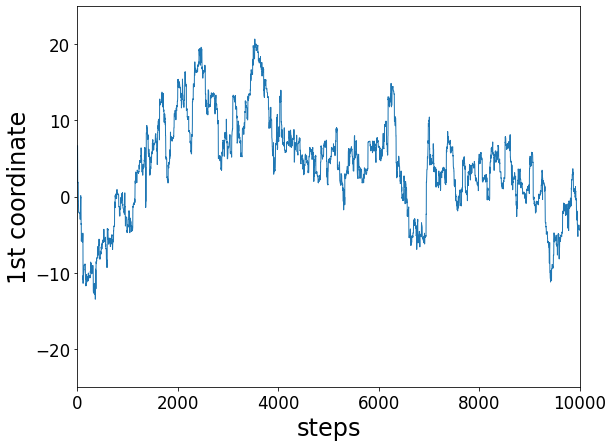

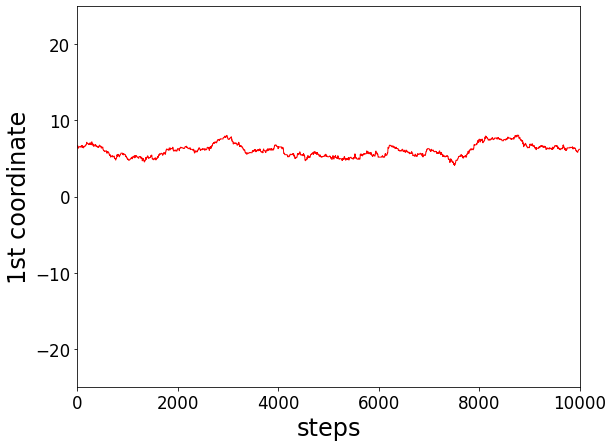

In [100]:
fontsize = 24
plt.plot(Locations50[:,0], linewidth=1)
fig = plt.gcf()
fig.set_size_inches(9,7)
plt.ylim(-25, 25);
plt.xlim(0, len(Locations50[:,0]));
plt.xlabel('steps', fontsize=fontsize)
plt.ylabel('1st coordinate', fontsize=fontsize)
plt.xticks(fontsize=0.7*fontsize)
plt.yticks(fontsize=0.7*fontsize);
plt.savefig('Skipping_50D_10000steps_1stcoordinate.png', dpi=300, bbox_inches='tight', pad_inches = 0.1)
plt.show()

plt.plot(LocationsRW50[:,0], color='red', linewidth=1)
fig = plt.gcf()
fig.set_size_inches(9,7)
plt.ylim(-25, 25);
plt.xlim(0, len(LocationsRW50[:,0]));
plt.xlabel('steps', fontsize=fontsize)
plt.ylabel('1st coordinate', fontsize=fontsize)
plt.xticks(fontsize=0.7*fontsize)
plt.yticks(fontsize=0.7*fontsize);
plt.savefig('RW_50D_10000steps_1stcoordinate.png', dpi=300, bbox_inches='tight', pad_inches = 0.1)
plt.show()

We compare the number of evaluation of the target distribution for the two algorithms

In [101]:
np.round(TargetEvaluations/TargetEvaluationsRW,3)

1.441

## Appendix: RWM tuning for dimension $d=50$

In [188]:
tuning_runs = 30
steps = 2000

PropVar = 0.007
PropCovariance = PropVar*np.identity(d)
InvCov = np.linalg.inv(PropCovariance)

AverageAcceptanceRate = np.zeros(tuning_runs)

for k in range(tuning_runs):
    
    # Variable initialization
    Location = InitialLocation # Same initial point as the Skipping Sampler 
    LocationsRW = np.zeros((steps, d)) # Allocate array for the whole trajectory
    AcceptedStepsRW = np.zeros(steps, dtype=int) # Keeps track of whether a step was accepted (1) or not (0)
    
    # Sample the starting point of the RWM by skipping from the origin
    np.random.seed(k) 
    IsOutside = True
    IntermediateLocation = np.zeros(d)
    Direction = GenerateDirection(d, PropCovariance)
    while IsOutside:
        IntermediateLocation = IntermediateLocation + GenerateDistance(d, Direction, InvCov,) * Direction;
        if BelongsToTail(IntermediateLocation, Threshold):
            IsOutside = False
    Location = IntermediateLocation 
    InitialLocation = Location

    # Trajectory generation
    t = time.time()
    np.random.seed(k)
    LogCoins = np.log(np.random.rand(steps)) # Pre-sample all accept-reject coins ahead of time
    for i in range(steps):
        LocationsRW[i] = Location

        # Gaussian RW proposal that to mirror the Skipping Sampler algorithm is performed in two steps:
        # 1) sampling a direction 
        # 2) sampling a distance conditionally on the direction sampled in (1)
        Direction = GenerateDirection(d, PropCovariance)
        ProposedLocation = Location + GenerateDistance(d, Direction, InvCov) * Direction

        # Acceptance/rejection step
        # Points which are not in the intrinsic tail are rejected automatically
        if NegativeLogTarget(Location) - NegativeLogTarget(ProposedLocation) >= LogCoins[i] and BelongsToTail(ProposedLocation, Threshold):
            Location = ProposedLocation
            AcceptedStepsRW[i] = 1

    elapsed = time.time() - t
    print("Run",k," Time = ",np.round(elapsed,3),"sec", "Average Acceptance Rate RW =",np.mean(AcceptedStepsRW))
    AverageAcceptanceRate[k] = np.mean(AcceptedStepsRW)
    
np.mean(AverageAcceptanceRate)

Run 0  Time =  2.499 sec Average Acceptance Rate RW = 0.223
Run 1  Time =  2.506 sec Average Acceptance Rate RW = 0.1745
Run 2  Time =  2.578 sec Average Acceptance Rate RW = 0.214
Run 3  Time =  2.626 sec Average Acceptance Rate RW = 0.2475
Run 4  Time =  2.631 sec Average Acceptance Rate RW = 0.2585
Run 5  Time =  2.615 sec Average Acceptance Rate RW = 0.303
Run 6  Time =  2.282 sec Average Acceptance Rate RW = 0.2285
Run 7  Time =  2.344 sec Average Acceptance Rate RW = 0.1605
Run 8  Time =  2.62 sec Average Acceptance Rate RW = 0.2535
Run 9  Time =  2.621 sec Average Acceptance Rate RW = 0.267
Run 10  Time =  2.6 sec Average Acceptance Rate RW = 0.2205
Run 11  Time =  2.411 sec Average Acceptance Rate RW = 0.173
Run 12  Time =  2.294 sec Average Acceptance Rate RW = 0.138
Run 13  Time =  2.608 sec Average Acceptance Rate RW = 0.2975
Run 14  Time =  2.277 sec Average Acceptance Rate RW = 0.1845
Run 15  Time =  2.444 sec Average Acceptance Rate RW = 0.1685
Run 16  Time =  2.611 sec A

0.2343833333333333